In [2]:
import os
import sys
sys.path.insert(0, os.path.abspath('..'))

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import helium

plotdir = '../../cvxportfolio/portfolio/plots/'
datadir='../../cvxportfolio/data/'

sigmas=pd.read_csv(datadir+'sigmas.csv.gz',index_col=0,parse_dates=[0]).iloc[:,:-1]
returns=pd.read_csv(datadir+'returns.csv.gz',index_col=0,parse_dates=[0])
volumes=pd.read_csv(datadir+'volumes.csv.gz',index_col=0,parse_dates=[0]).iloc[:,:-1]

#, 'NKE', 'IBM', 'BAC', 'C'
subset_tickers = ['AMZN', 'GOOGL', 'BAC', 'USDOLLAR']
sigmas = sigmas.ix[:, sigmas.columns.isin(subset_tickers)]
returns = returns.ix[:, returns.columns.isin(subset_tickers)]
volumes = volumes.ix[:, volumes.columns.isin(subset_tickers)]

start_date="2012-02-01"
end_date="2016-12-29"

/home/yowtzu/anaconda/envs/cvxportfolio/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/home/yowtzu/anaconda/envs/cvxportfolio/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/home/yowtzu/anaconda/envs/cvxportfolio/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [4]:
cash_ticker = "_CASH"

In [5]:
sigmas[cash_ticker] = 0.
returns = returns.rename(columns={"USDOLLAR": cash_ticker})
volumes[cash_ticker] = np.finfo(np.float).max

In [6]:
w_b = pd.Series(index=returns.columns, data=1)
w_b._CASH = 0.
w_b/=sum(w_b)


In [7]:
return_estimate=pd.read_csv(datadir+'return_estimate.csv.gz',index_col=0,parse_dates=[0]).dropna()
volume_estimate=pd.read_csv(datadir+'volume_estimate.csv.gz',index_col=0,parse_dates=[0]).iloc[:,:-1].dropna()
sigma_estimate=pd.read_csv(datadir+'sigma_estimate.csv.gz',index_col=0,parse_dates=[0]).iloc[:,:-1].dropna()

return_estimate = return_estimate.ix[:, return_estimate.columns.isin(subset_tickers)]
volume_estimate = volume_estimate.ix[:, volume_estimate.columns.isin(subset_tickers)]
sigma_estimate = sigma_estimate.ix[:, sigma_estimate.columns.isin(subset_tickers)]

/home/yowtzu/anaconda/envs/cvxportfolio/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """
/home/yowtzu/anaconda/envs/cvxportfolio/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
/home/yowtzu/anaconda/envs/cvxportfolio/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys


In [8]:
sigma_estimate[cash_ticker] = 0.
return_estimate = return_estimate.rename(columns={"USDOLLAR": cash_ticker})
volume_estimate[cash_ticker] = np.finfo(np.float).max

In [9]:
borrow_costs = returns.copy()
borrow_costs[:] = 1E-4
borrow_costs[cash_ticker] = 0.

dividends = returns.copy()
dividends[:] = 0.

simulated_hcost=helium.HoldingCost(gamma = 1., borrow_costs=borrow_costs, dividends=dividends)
simulated_tcost=helium.TransactionCost(gamma =1.0, 
                                             half_spread=0.0005/2,
                                             nonlin_coef = 1.,
                                             sigmas = sigmas, 
                                             nonlin_power = 1.5,
                                             volumes = volumes,
                                             asym_coef = 0.)

simulator = helium.MarketSimulator(returns, volumes, costs=[
#    simulated_tcost, 
#    simulated_hcost
], cash_ticker=cash_ticker)

In [10]:
r_est_dict = {}
d_est_dict = {}
for day in return_estimate.index[:-1]:
    rrr = return_estimate.loc[day:].iloc[:2].copy()
    r_est_dict[day] = rrr
    deltas = rrr.copy()
    deltas[:] = 0.
    d_est_dict[day] = deltas

In [11]:
r= helium.DefaultRet(r_est_dict,  d_est_dict , gamma_decay=None)
#Sigma_hat = returns.rolling(window=250, min_periods=250).cov().unstack().shift(1).stack().dropna()

In [12]:
Sigma_hat = returns.rolling(window=250, min_periods=250).cov().unstack().shift(1).stack().dropna()

In [13]:
d_est_dict[pd.to_datetime('2016-12-29')]

,GOOGL,AMZN,BAC,_CASH
Date,,,,
2016-12-29,0.0,0.0,0.0,0.0
2016-12-30,0.0,0.0,0.0,0.0


In [14]:
??helium.BasicRiskCost

In [15]:
policies = {}
results = {}
gamma_risks_coarse=[.1,.3,1, ]#3,10,30,100,300,1000]
gamma_tcosts_coarse=[1., 2.]#, 5,10,20]
for gamma_risk in gamma_risks_coarse:
    for gamma_tcost in gamma_tcosts_coarse: 
        print(gamma_risk, gamma_tcost)
        risk_model = helium.BasicRiskCost(gamma_risk, Sigma_hat)
        optimization_hcost = helium.HoldingCost(gamma = 1., borrow_costs=borrow_costs, dividends=dividends)
        optimization_tcost = helium.TransactionCost(gamma_tcost, 
                                                    half_spread=0.0005/2., 
                                                    nonlin_coef = 1.,
                                                    sigmas = sigma_estimate, 
                                                    nonlin_power = 1.5,
                                                    volumes = volume_estimate,
                                                    asym_coef = 0.)
        
        # issue optimization_tcost
        costs = [
           # risk_model, 
          #       optimization_tcost, 
          #       optimization_hcost
                ]
        const = [helium.LeverageLimitConstraint(3)]
        policies[(gamma_risk, gamma_tcost)] = helium.MultiPeriodOpt(r, [], const, 2)
        results[(gamma_risk, gamma_tcost)] = simulator.run(1E8*w_b, 
                                                         policies[(gamma_risk, gamma_tcost)],
                                                         start_date, 
                                                         end_date)

0.1 1.0
0.1 2.0
0.3 1.0
0.3 2.0
1 1.0
1 2.0


In [63]:
result_df_coarse=pd.DataFrame()
for k in results:
    if k[0] in gamma_risks_coarse and k[1] in gamma_tcosts_coarse:
        result_df_coarse.loc[k[0], k[1]] = results[k]
        
result_df = result_df_coarse.loc[sorted(result_df_coarse.index), sorted(result_df_coarse.columns)]

[51.104710385043994, 51.104710385046026, 51.10471038503438] [145.5371250496302, 145.5371250490975, 145.53712504953006]
[51.10471038503493, 51.10471038504173, 51.10471038505016] [145.5371250495919, 145.53712504970386, 145.53712504936655]


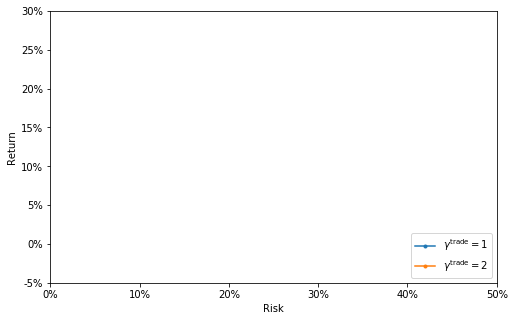

In [64]:
plt.figure(figsize=(8,5))
for gamma_tcost in result_df.columns:
    x=[el.excess_returns.std()*100*np.sqrt(250) for el in result_df[gamma_tcost]]
    y=[el.excess_returns.mean()*100*250 for el in result_df[gamma_tcost]]
    print(x,y)
    plt.plot(np.array(x),np.array(y), '.-', label='$\gamma^\mathrm{trade} = %g$'%gamma_tcost)
plt.legend(loc='lower right')
plt.xlabel('Risk')
plt.ylabel('Return')
plt.xlim([0,50])
plt.ylim([-5,30])


import matplotlib.ticker as mtick
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))

#plt.savefig(plotdir+'spo_riskrewardfrontier.png')

### Fine Search

In [14]:
policies = {}
results = {}
gamma_risks_fine=gamma_risks_coarse
gamma_tcosts_fine=[4,5,6,7,8]
for gamma_risk in gamma_risks_fine:
    for gamma_tcost in gamma_tcosts_fine: 
        risk_model = helium.BasicRiskCost(gamma_risk, Sigma_hat)
        optimization_hcost = helium.HoldingCost(gamma = 1., borrow_costs=borrow_costs, dividends=dividends)
        optimization_tcost = helium.TransactionCost(gamma_tcost, 
                                                    half_spread=0.0005/2., 
                                                    nonlin_coef = 1.,
                                                    sigmas = asigma_estimate, 
                                                    nonlin_power = 1.5,
                                                    volumes = volume_estimate,
                                                    asym_coef = 0.)
        
        # issue optimization_tcost
        costs = [
            risk_model, 
                 optimization_tcost, 
                 optimization_hcost
                ]
        const = [helium.LeverageLimitConstraint(3)]
        policies[(gamma_risk, gamma_tcost)] = helium.SinglePeriodOpt(r, costs, const)
        results[(gamma_risk, gamma_tcost)] = simulator.run(1E8*w_b, 
                                                         policies[(gamma_risk, gamma_tcost)],
                                                         start_date, 
                                                         end_date)

In [15]:
result_df_fine=pd.DataFrame()
for k in results:
    if k[0] in gamma_risks_fine and k[1] in list(gamma_tcosts_fine):
        result_df_fine.loc[k[0], k[1]] = results[k]
        
result_df_fine=result_df_fine.loc[sorted(result_df_fine.index),sorted(result_df_fine.columns)]

In [16]:
plt.figure(figsize=(8,5))
for gamma_tcost in result_df_fine.columns[:]:
    x=[el.excess_returns.std()*100*np.sqrt(250) for el in result_df_fine[gamma_tcost]]
    y=[el.excess_returns.mean()*100*250 for el in result_df_fine[gamma_tcost]]
    print(x,y)
    plt.plot(np.array(x),np.array(y), '.-', label='$\gamma^\mathrm{trade} = %g$'%gamma_tcost)
plt.legend(loc='lower right')
plt.xlabel('Risk')
plt.ylabel('Return')
plt.xlim([0,20])
plt.ylim([0,30])


import matplotlib.ticker as mtick
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))

#plt.savefig(plotdir+'spo_riskrewardfrontier_fine.png')

### Pareto

In [17]:
results_pareto={}

In [64]:
policies = {}
#results = {}
gamma_risks_pareto=[0.1, 0.17782, 0.31624, 0.562, 1.0, 2, 3, 6, 10, 18, 32, 56, 100, 178, 316, 562, 1000]
gamma_tcosts_pareto=[5.5,6,6.5,7,7.5,8]
gamma_holdings=[.1,1.,10.,100.]
for gamma_risk in gamma_risks_pareto:
    for gamma_tcost in gamma_tcosts_pareto : 
        for gamma_holding in gamma_holdings:
            risk_model = helium.BasicRiskCost(gamma_risk, Sigma_hat)
            optimization_hcost = helium.HoldingCost(gamma_holding , borrow_costs=borrow_costs, dividends=dividends)
            optimization_tcost = helium.TransactionCost(gamma_tcost, 
                                                    half_spread=0.0005/2., 
                                                    nonlin_coef = 1.,
                                                    sigmas = sigma_estimate, 
                                                    nonlin_power = 1.5,
                                                    volumes = volume_estimate,
                                                    asym_coef = 0.)
        
            # issue optimization_tcost

            costs = [risk_model,    optimization_tcost,                  optimization_hcost  ]
            const = [helium.LeverageLimitConstraint(3)]
            policies[(gamma_risk, gamma_tcost, gamma_holding)] = helium.MultiPeriodOpt(r, costs, const, steps=1)
            results_pareto[(gamma_risk, gamma_tcost, gamma_holding)] = simulator.run(1E8*w_b, 
                                                         policies[(gamma_risk, gamma_tcost, gamma_holding)],
                                                         start_date, 
                                                         end_date)

KeyError: Timestamp('2016-12-30 00:00:00')

In [ ]:
len(results_pareto)

In [ ]:
table=pd.DataFrame()
table[r'$\gamma^\mathrm{risk}$']=[el[0] for el in results_pareto.keys()]
table[r'$\gamma^\mathrm{trade}$']=[el[1] for el in results_pareto.keys()]
table[r'$\gamma^\mathrm{hold}$']=['%g'%el[2] for el in results_pareto.keys()]
table['Return']=[(results_pareto[k].excess_returns.mean()*100*250) for k in results_pareto.keys()]
table['Risk']=[(results_pareto[k].excess_returns.std()*100*np.sqrt(250)) for k in results_pareto.keys()]
table = table.sort_values('Risk', ascending=False).reset_index()
del table['index']
is_pareto = lambda i: table.loc[i,'Return']>=max(table.ix[i:].Return)
table['is_pareto'] = [is_pareto(i) for i in range(len(table))]
#table.to_csv(datadir+'spo_pareto_results.csv', float_format='%g')

In [ ]:
plt.figure(figsize=(8,5))
plt.scatter(table.Risk.values,table.Return.values)
plt.plot(table[table.is_pareto].Risk,table[table.is_pareto].Return, 'C1.-', label='Pareto optimal frontier')
plt.legend( loc='lower right')
plt.xlabel('Risk')
plt.ylabel('Return')
plt.xlim([0,20])
plt.ylim([0,30])

import matplotlib.ticker as mtick
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))

#plt.savefig(plotdir+'spo_pareto.png')

In [ ]:
xlim=20
ylim=30
table=table[table.is_pareto]
table=table[table.Risk <= xlim]
table=table[table.Return <= ylim]
del table['is_pareto']
table.Risk=table.Risk.apply(lambda x: '%.2f%%'%x)
table.Return=table.Return.apply(lambda x: '%.2f%%'%x)
print(table.iloc[::-1].to_latex(float_format='%.2f', escape=False, index=False).replace('%',r'\%'))

In [ ]:
table.tail(50)